<a href="https://colab.research.google.com/github/AddChew/TextAnalytics/blob/main/SingBERT_Hdbscan_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installation of libraries
!pip install transformers
!pip install umap-learn
!pip install hdbscan
!pip install wordcloud

     |████████████████████████████████| 2.3MB 7.6MB/s 
     |████████████████████████████████| 901kB 49.2MB/s 
     |████████████████████████████████| 3.3MB 48.3MB/s 
     |████████████████████████████████| 81kB 5.5MB/s 
     |████████████████████████████████| 1.2MB 13.0MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=5e9c02ffcc43fb9a45af93b8bbf0a375c2f451b323b2493c33665026a0b11f38
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51362 sha256=e2abdb2c40c1bfbbd67fb2b5e84d5ebde3b1dda60abc048d33e3caec9287d7a8
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent
     |████████████████████████████████| 6.4MB 7.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    

In [18]:
# Import the necessary libraries
import os
import re
import umap
import torch
import hdbscan
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Set pandas settings
pd.set_option('mode.chained_assignment',None)

# Set plot settings
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 50, 'linewidths':0}

In [4]:
# Mount the drive
drive.mount('/content/gdrive/')

# Change working directory
os.chdir('/content/gdrive/My Drive/ICA/WOGAA-Feedback')

Mounted at /content/gdrive/


In [6]:
class SummaryStats:

  def __init__(self, tokenizer, feedbackList, maxLength = 64):
    self.tokenizer = tokenizer
    self.feedbackList = feedbackList
    self.maxLength = maxLength
    self.summaryStats()


  def calcNumTokens(self):
    return [len(self.tokenizer.encode(feedback)) for feedback in self.feedbackList]


  def plotDistTokens(self, numTokens):
    sns.distplot(numTokens, kde=False)


  def summaryStats(self):
    numTokens = self.calcNumTokens()
    self.plotDistTokens(numTokens)
    numTokens_df = pd.DataFrame(numTokens)

    print('Min num of tokens: {}'.format(numTokens_df.min()[0]))
    print('Max num of tokens: {}\n'.format(numTokens_df.max()[0]))

    print('Mode num of tokens: {}'.format(numTokens_df.iloc[:,0].mode()[0]))
    print('Mean num of tokens: {}'.format(numTokens_df.iloc[:,0].mean()))
    print('Median num of tokens: {}\n'.format(numTokens_df.iloc[:,0].median()))

    print('75 percentile num of tokens: {}'.format(numTokens_df.iloc[:,0].quantile(.75)))
    print('90 percentile num of tokens: {}'.format(numTokens_df.iloc[:,0].quantile(.9)))
    print('95 percentile num of tokens: {}'.format(numTokens_df.iloc[:,0].quantile(.95)))
    print('99 percentile num of tokens: {}\n'.format(numTokens_df.iloc[:,0].quantile(.99)))

    print('Number of truncated comments if threshold is set to {}: {}'.format(
        self.maxLength,
        numTokens_df[numTokens_df.iloc[:,0] > self.maxLength].shape[0]
        ))

In [7]:
class Feedback2Vec:

  def __init__(self, tokenizer, encoder, feedbackList, batchSize = 64):
    self.tokenizer = tokenizer
    self.encoder = encoder
    self.feedbackList = feedbackList
    self.batchSize = batchSize
    

  def setMaxLength(self, maxLength = 64):
    self.maxLength = maxLength
    input_seq, input_mask = self.tokenize()
    dataLoader = self.loadIntoDataLoader(input_seq, input_mask)
    self.avg_embeddings = self.encode(dataLoader)
    self.get_UMAP_embeddings()


  def tokenize(self):
    input_seq, input_type, input_mask = self.tokenizer.batch_encode_plus(
        self.feedbackList,
        max_length = self.maxLength,
        padding = True,
        truncation = True,
        return_tensors='pt').values()
    return input_seq, input_mask


  def loadIntoDataLoader(self, input_seq, input_mask):
    data = TensorDataset(input_seq, input_mask)
    return DataLoader(data, shuffle = False, batch_size = self.batchSize, num_workers=8)


  def encode(self, dataLoader):
    for input, attention in dataLoader:
      input, attention = input.cuda(), attention.cuda()

      with torch.no_grad():
        output = self.encoder(input, attention)
      try:
        avg_embeddings = np.append(avg_embeddings, torch.mean(output.last_hidden_state, dim=1).detach().cpu().numpy(), axis=0)
      except:
        avg_embeddings = torch.mean(output.last_hidden_state, dim=1).detach().cpu().numpy()
    return avg_embeddings


  def get_UMAP_embeddings(self, n_neighbors = 15, n_components = 5):
    self.umap_avg_embeddings = umap.UMAP(n_neighbors = n_neighbors, 
                                         n_components = n_components, 
                                         metric='cosine').fit_transform(self.avg_embeddings)

In [34]:
class MyWordCloud:
  
  def __init__(self, top5Dataframe, cluster_labels):
    top5Dataframe["Feedback_with_bigrams"] = top5Dataframe["Feedback"].apply(self.addBigram)
    for column, labels in cluster_labels.items():
      top5Dataframe[column] = labels
    self.top5Dataframe = top5Dataframe
    self.topicColumns = cluster_labels.keys()
    self.top_n_words = {}
    self.createDocument()


  @staticmethod
  def addBigram(feedback):
    feedback = re.sub(r'[^a-z ]', '', feedback.lower())
    tokens = feedback.split()
    bigrams = [''.join(tokens[i:i+2]) for i in range(len(tokens)-1)]
    return ' '.join([word for word in (tokens + bigrams)])


  def createDocument(self):
    for topicColumn in self.topicColumns:
      setattr(self, topicColumn, self.top5Dataframe.groupby([topicColumn], as_index = False).agg({'Feedback_with_bigrams': ' '.join}))


  def extract_top_n_words(self, n = 20, stopwords = 'english'):
    for topicColumn in self.topicColumns:
      document = getattr(self, topicColumn)
      document = document[document[topicColumn] != -1]

      vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords)
      document_term_matrix = vectorizer.fit_transform(document["Feedback_with_bigrams"]).toarray()
      vocab = vectorizer.get_feature_names()

      self.top_n_words[topicColumn] = {doc:[(vocab[word], document_term_matrix[doc][word]) for word in document_term_matrix.argsort(axis=1)[:, -n:][doc][::-1]] for doc in document[topicColumn].tolist()}

  
  def plotWordCloud(self, topicColumn):
    print("{}:".format(topicColumn))
    for topicNo, topic in self.top_n_words[topicColumn].items():
      word_freq = {word:score for word, score in topic}
      wordcloud = WordCloud(width = 3000, 
                            height = 2000, 
                            random_state=0, 
                            background_color='black', 
                            colormap='Set2', 
                            collocations=False).fit_words(word_freq)
      plt.figure(figsize=(15,10))
      plt.title('Topic {}\n'.format(topicNo))
      plt.axis('off')
      plt.imshow(wordcloud)

In [36]:
class TopicModel:

  def __init__(self, top5Dataframe, tokenizer, encoder, batchSize = 64):
    self.top5Dataframe = top5Dataframe
    self.feedbackList = self.top5Dataframe["Feedback"].values.tolist()
    self.feedback2Vec = Feedback2Vec(tokenizer, encoder, self.feedbackList, batchSize)
    

  def setMaxLength(self, maxLength = 64):
    self.feedback2Vec.setMaxLength(maxLength)


  def getSummaryStats(self, maxLength = 64):
    SummaryStats(self.feedback2Vec.tokenizer, self.feedbackList, maxLength)


  def getClusters(self, embeddings, min_cluster_size = 15, min_samples = 1):
    return hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                           min_samples = min_samples).fit(embeddings).labels_


  def prepareWordCloud(self, n = 20):
    self.clusters = {
        "Without_UMAP": self.getClusters(self.feedback2Vec.avg_embeddings),
        "With_UMAP": self.getClusters(self.feedback2Vec.umap_avg_embeddings)
                     }
    self.wordcloud = MyWordCloud(self.top5Dataframe, self.clusters)
    self.top5Dataframe = self.wordcloud.top5Dataframe
    self.wordcloud.extract_top_n_words(n = n, stopwords = 'english')


  def plotWordClouds(self, n = 20):
    self.prepareWordCloud(n = n)
    for key in self.clusters:
      yield self.wordcloud.plotWordCloud(key)


  def saveToExcel(self, savePath):
    dataframe_to_save = self.top5Dataframe.drop(columns=["Feedback_with_bigrams"])
    dataframe_to_save.to_csv(savePath, index = False)
    print("Clustering Results have been saved successfully to {}!".format(savePath))

**Load Data From Excel**

In [5]:
# Load Sentiments excel file
sentiments = pd.read_excel("./data/Cleaned WOGAA Sentiments for Q1-2021.xlsx", sheet_name=None)

# Get top 5 services with the most feedback collected and save their data into a dictionary for further use
top5_dict = {}
for sheetname, sheet in sentiments.items():
  print("{}:".format(sheetname))

  top5counts = sheet.groupby(["Service", "Question"]).count().sort_values(by=["Feedback"], ascending=False).head(5)
  print(top5counts)
  print("\n")

  for index in top5counts.index:
    service, qns = index
    top5_dict[index] = sheet[(sheet.Service == service) & (sheet.Question == qns)]
    top5_dict[index].Feedback = top5_dict[index].Feedback.str.replace(r"[^a-zA-Z0-9\s!.,']", "")

TS sentiments:
                                                                             Feedback
Service                                            Question                          
SG Arrival Card                                    What did you like least?       172
IC Re-registration for 30/55-year-olds Singapor... What did you like most?        103
IC Registration for 15-year-olds                   What did you like most?         90
SG Arrival Card                                    What did you like most?         76
STO Portal                                         What did you like least?        71


IS sentiments:
                                                Feedback
Service               Question                          
ICA eServices         What did you like least?      1440
                      What did you like most?        614
SafeTravel            What did you like least?       216
ICA Corporate Website What did you like least?       144
SafeTravel            Wh

**Load Tokenizer and Encoder**

In [10]:
# Load singBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('zanelim/singbert')

# Load singBERT encoder
encoder = BertModel.from_pretrained("zanelim/singbert").cuda()
encoder.eval()

Some weights of the model checkpoint at zanelim/singbert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### **ICA eServices (What did you like least?)**

In [37]:
topicModel = TopicModel(top5_dict[('ICA eServices ', 'What did you like least?')], tokenizer, encoder)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Min num of tokens: 2
Max num of tokens: 277

Mode num of tokens: 6
Mean num of tokens: 20.79652777777778
Median num of tokens: 14.0

75 percentile num of tokens: 26.0
90 percentile num of tokens: 43.100000000000136
95 percentile num of tokens: 60.0
99 percentile num of tokens: 101.6099999999999

Number of truncated comments if threshold is set to 60: 70


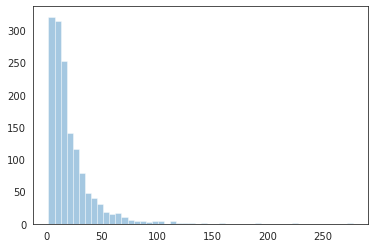

In [38]:
# Determine optimal max length to set; i.e. max length = 60 seems like a reasonable pick
topicModel.getSummaryStats(60)

In [39]:
# Let's set max length to 60
topicModel.setMaxLength(maxLength = 60)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [40]:
# Let's plot some word clouds 
wordclouds = topicModel.plotWordClouds(n = 20)

**Without UMAP**

Without_UMAP:


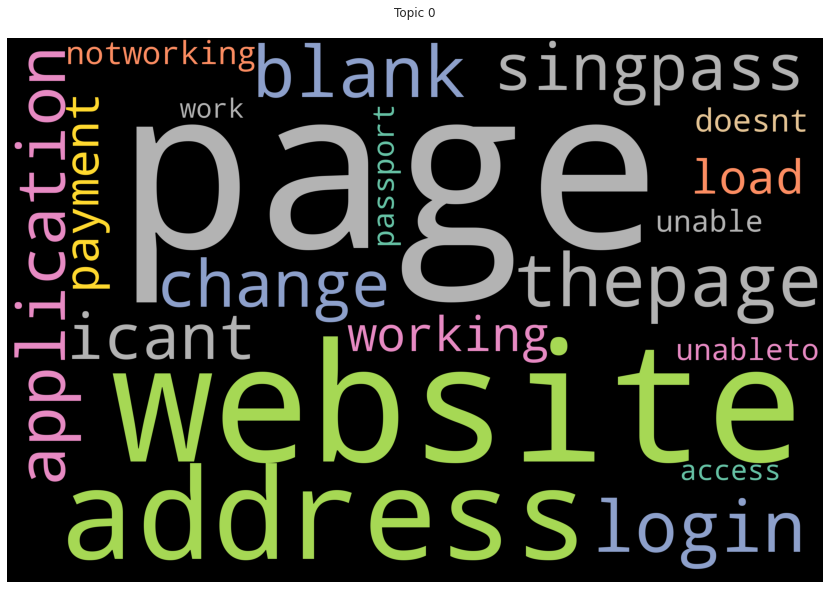

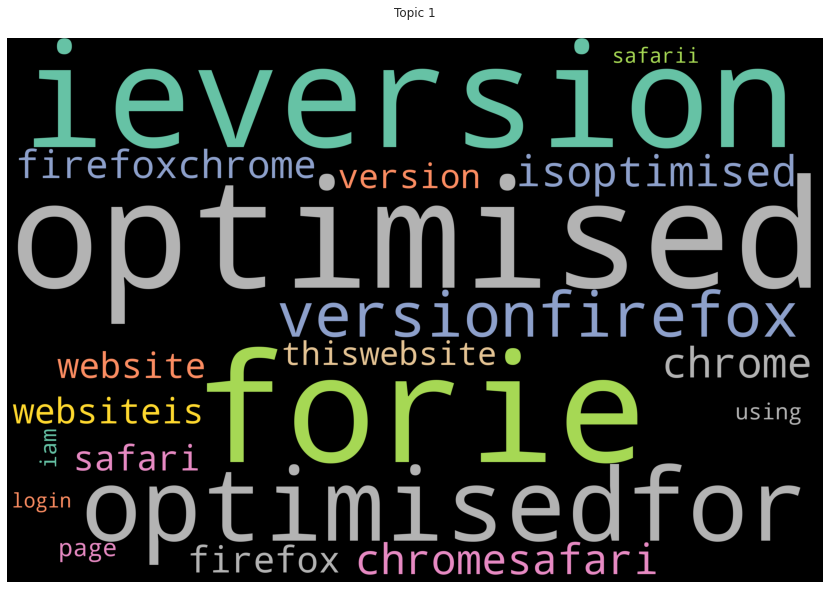

In [41]:
next(wordclouds)

**With UMAP**

With_UMAP:


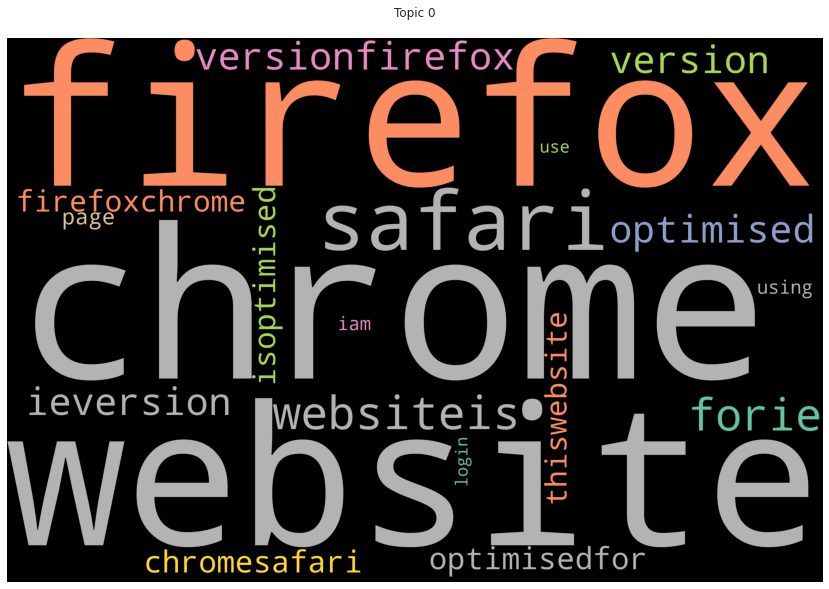

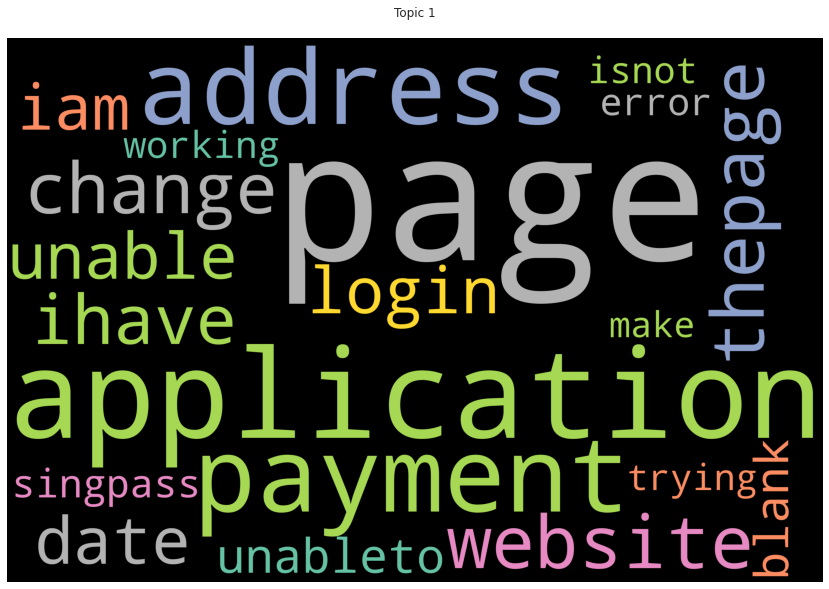

In [42]:
next(wordclouds)

In [43]:
# Output clustering results to a csv file
topicModel.saveToExcel(savePath = "./Clustering Results/ICA eServices Negative Feedback Results.csv")

Clustering Results have been saved successfully to ./Clustering Results/ICA eServices Negative Feedback Results.csv!
